In [51]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Sans'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# E-Mini S&P500先物と金先物データ読み込み

In [15]:
dfsp_tmp = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
dfg_tmp = pd.read_csv(f'data/gold-200626/gold-daily.csv')
dfs = [dfsp_tmp, dfg_tmp]

# datetime indexに変換
def to_datetime_index(df):
    # DateTime列を追加
    df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    df = df.set_index('datetime', drop=True)
    df = df.drop(columns=['Date', 'Time'])
    return df

dfs = [to_datetime_index(df) for df in dfs]

# 対数変換した列を追加
def add_log_values(df):
    df['logO'] = np.log(df['Open'])
    df['logH'] = np.log(df['High'])
    df['logL'] = np.log(df['Low'])
    df['logC'] = np.log(df['Close'])
    df['logV'] = np.log(df['Vol'])
    df['logOI'] = np.log(df['OI'])

_ = [add_log_values(df) for df in dfs]

/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 価格、対数価格、価格階差、対数差収益率（100倍）のDFを作成

In [29]:
def to_log_return_ratio_df(df):
    diff_df = df.diff()
    close_df = df[['Close', 'logC']]
    diff_df = diff_df.rename(columns={'Close': 'CloseDiff', 'logC': 'logCDiff'})
    close_diff_df = diff_df[['CloseDiff', 'logCDiff']]
    rr_df = pd.concat([close_df, close_diff_df], axis=1)
    rr_df = rr_df.dropna()
    return rr_df

rr_dfs = [to_log_return_ratio_df(df) for df in dfs]

# 2019年の1年間のみのデータ

In [34]:
rrdfs2019 = [df[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)] for df in rr_dfs]

In [35]:
rrdfs2019

[                       Close      logC  CloseDiff  logCDiff
 datetime                                                   
 2019-01-02 17:00:00  2513.75  7.829531       5.75  0.002290
 2019-01-03 17:00:00  2450.50  7.804047     -63.25 -0.025484
 2019-01-04 17:00:00  2534.00  7.837554      83.50  0.033507
 2019-01-07 17:00:00  2553.25  7.845122      19.25  0.007568
 2019-01-08 17:00:00  2575.25  7.853702      22.00  0.008580
 ...                      ...       ...        ...       ...
 2019-12-24 17:00:00  3214.50  8.075427      -1.50 -0.000467
 2019-12-26 17:00:00  3233.25  8.081243      18.75  0.005816
 2019-12-27 17:00:00  3226.25  8.079076      -7.00 -0.002167
 2019-12-30 17:00:00  3212.25  8.074727     -14.00 -0.004349
 2019-12-31 17:00:00  3219.75  8.077059       7.50  0.002332
 
 [252 rows x 4 columns],
                       Close      logC  CloseDiff  logCDiff
 datetime                                                  
 2019-01-02 17:00:00  1359.4  7.214799        2.8  0.002062


# 価格と対数差収益率を比較

## E-Mini S&P500先物

Text(0.5, 1.0, '2019年のE-Mini S&P500先物の終値（上）とその対数差収益率（下）')

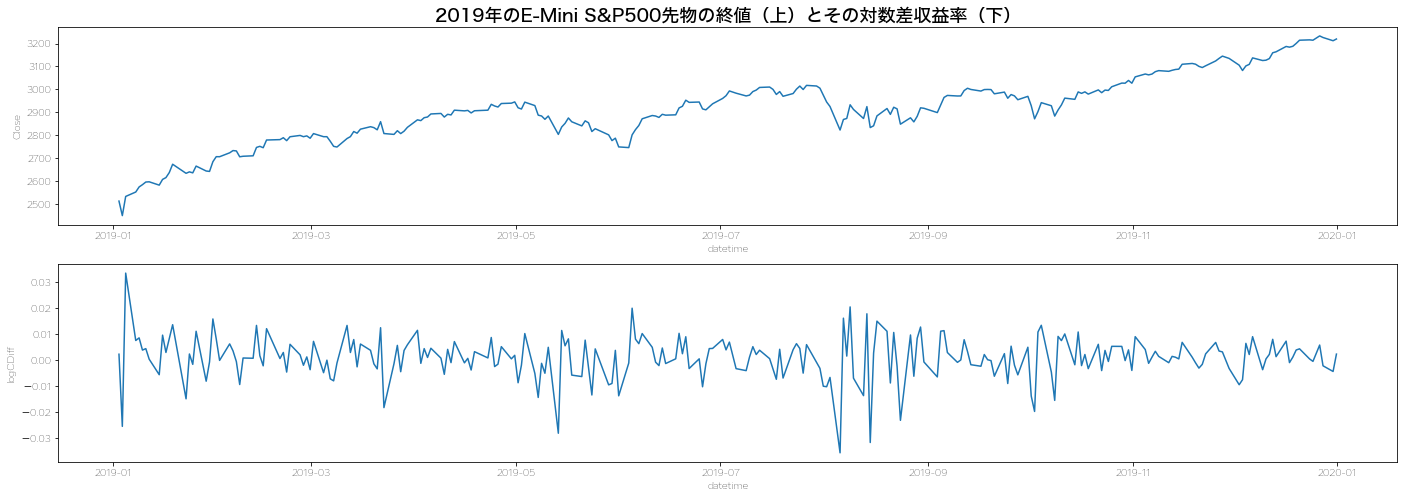

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(24, 8))
sns.lineplot(rrdfs2019[0].index, rrdfs2019[0]['Close'], ax=ax[0])
sns.lineplot(rrdfs2019[0].index, rrdfs2019[0]['logCDiff'], ax=ax[1])
ax[0].set_title('2019年のE-Mini S&P500先物の終値（上）とその対数差収益率（下）', fontsize=18, fontweight='bold')

Text(0.5, 1.0, '2019年の金先物の終値（上）とその対数差収益率（下）')

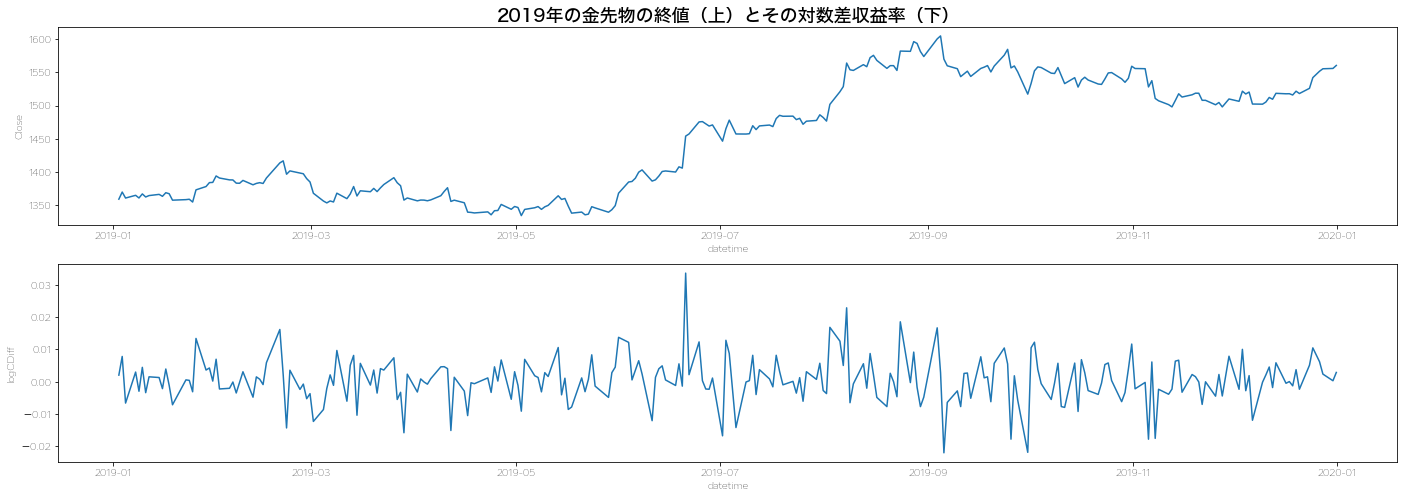

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(24, 8))
sns.lineplot(rrdfs2019[1].index, rrdfs2019[1]['Close'], ax=ax[0])
sns.lineplot(rrdfs2019[1].index, rrdfs2019[1]['logCDiff'], ax=ax[1])
ax[0].set_title('2019年の金先物の終値（上）とその対数差収益率（下）', fontsize=18, fontweight='bold')